# An introduction to [`nilearn`](http://nilearn.github.io)

In this tutorial, we'll see how the Python library _nilearn_ allows us to easily perform machine learning analyses with neuroimaging data, specifically MRI and fMRI.

You may notice that the name `nilearn` is reminiscent of [`scikit-learn`](https://scikit-learn.org),
a popular Python library for machine learning.
This is no accident!
Nilearn and scikit-learn were created by the same team,
and nilearn is designed to bring machine **LEARN**ing to the NeuroImaging (**NI**) domain.

With that in mind, let's briefly consider why we might want specialized tools for working with neuroimaging data.
When performing a machine learning analysis, our data often look something like this:

NB: update to Tal's example once uploaded !

In [1]:
from sklearn import datasets

diabetes = datasets.load_diabetes(as_frame=True)
diabetes.data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


This data is clearly structured in a tabular format.
This makes it easier to consider issues such as: which features would we like to predict?
Or, how do we handle cross-validation?

## Neuroimaging data

By contrast, neuroimaging data has a very different structure.
Neuroimaging data has both spatial and temporal dependencies between successive data points.
That is, knowing _where_ and _when_ something was measured tells you information about the surrounding data points.
We also know that neuroimaging data contains a lot of noise that's not blood-oxygen-level dependent (BOLD), such as head motion.
Since we don't think that these other noise sources are related to neuronal firing,
we often need to consider how we can make sure that our analyses are not driven by these noise sources.
These are all considerations that most machine learning software libraries are not designed to deal with !
Nilearn therefore plays a crucial role in bringing machine learning concepts to the neuroimaging domain.

To get a sense of the problem, the quickest method is to just look at some neuroimaging data.
You may have your own data locally that you'd like to work with.
Nilearn also provides access to several neuroimaging data sets and atlases (we'll talk about these a bit later).
These data sets (and atlases) are only accessible because research groups chose to make their collected data publicly available.
We owe them a huge thank you for this !
The data set we'll use today was originally collected by [Rebecca Saxe](https://mcgovern.mit.edu/profile/rebecca-saxe/)'s group at MIT and hosted on [OpenNeuro](https://openneuro.org/datasets/ds000228/versions/1.1.0).

The nilearn team preprocessed the data set with [fMRIPrep](https://fmriprep.readthedocs.io) and downsampled it to a lower resolution,
so it'd be easier to work with.
We can learn a lot about this data set directly [from the Nilearn documentation](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_development_fmri.html)!
For example, we can see that this data set contains over 150 children and adults watching a short Pixar film.
Let's download the first 30 participants.

In [2]:
from nilearn import datasets

development_dataset = datasets.fetch_development_fmri(n_subjects=30)


Dataset created in /home/runner/nilearn_data/development_fmri


Dataset created in /home/runner/nilearn_data/development_fmri/development_fmri



Downloaded 16041 of 16041 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68285 of 68285 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5642698 of 5642698 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 67851 of 67851 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 4946416 of 4946416 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 69170 of 69170 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5875966 of 5875966 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68464 of 68464 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5845425 of 5845425 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68189 of 68189 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6522229 of 6522229 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 69463 of 69463 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6139107 of 6139107 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68468 of 68468 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6293165 of 6293165 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68130 of 68130 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6136523 of 6136523 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68340 of 68340 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5837641 of 5837641 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 71331 of 71331 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6118892 of 6118892 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68533 of 68533 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6453693 of 6453693 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68590 of 68590 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6176491 of 6176491 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68630 of 68630 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6225801 of 6225801 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68331 of 68331 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6232787 of 6232787 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 68425 of 68425 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 7361169 of 7361169 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68894 of 68894 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6586819 of 6586819 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68848 of 68848 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6111716 of 6111716 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68243 of 68243 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6067448 of 6067448 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 69265 of 69265 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6122113 of 6122113 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68479 of 68479 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6295931 of 6295931 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68301 of 68301 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6384587 of 6384587 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 67912 of 67912 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 5934622 of 5934622 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68499 of 68499 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6316470 of 6316470 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 67733 of 67733 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6020576 of 6020576 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68275 of 68275 bytes (100.0%,    0.0s remaining) ...done. (2 seconds, 0 min)


Downloaded 6551822 of 6551822 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68896 of 68896 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6116459 of 6116459 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68182 of 68182 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6752586 of 6752586 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68403 of 68403 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6023997 of 6023997 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 68534 of 68534 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6312316 of 6312316 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 69162 of 69162 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 6031594 of 6031594 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Now, this `development_dataset` object has several attributes which provide access to the relevant information.
For example, `development_dataset.phenotypic` provides access to information about the participants, such as whether they were children or adults.
We can use `development_dataset.func` to access the functional MRI (fMRI) data.

## Getting into the data: subsetting and viewing

Nilearn also provides many methods for plotting this kind of data.
For example, we can use [`nilearn.plotting.view_img`](https://nilearn.github.io/modules/generated/nilearn.plotting.view_img.html) to launch at interactive viewer.
Because each fMRI run is a 4D time series (three spatial dimensions plus time),
we'll also need to subset the data when we plot it, so that we can look at a single 3D image.
Nilearn provides (at least) two ways to do this: with [`nilearn.image.index_img`](https://nilearn.github.io/modules/generated/nilearn.image.index_img.html),
which allows us to index a particular frame--or several frames--of a time series,
and [`nilearn.image.mean_img`](https://nilearn.github.io/modules/generated/nilearn.image.mean_img.html),
which allows us to take the mean 3D image over time.

Putting these together, we can interatively view the mean image of the first participant using:


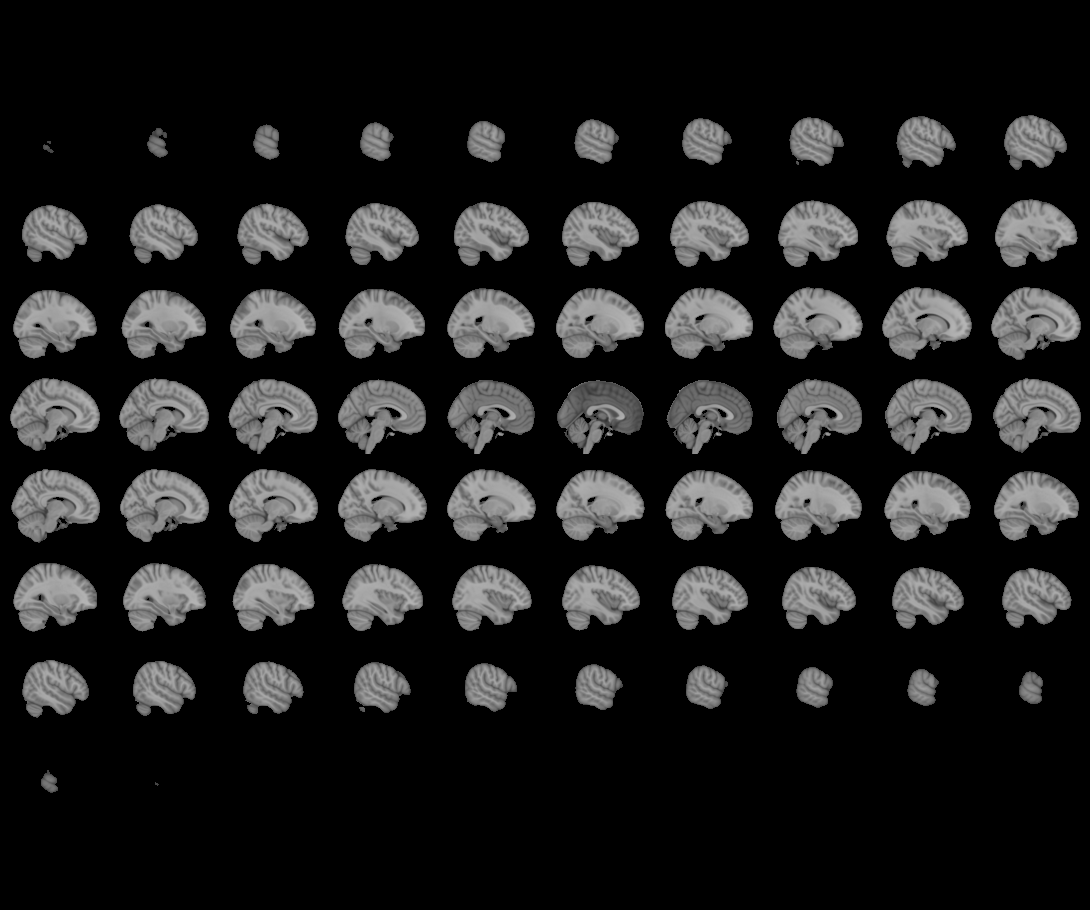
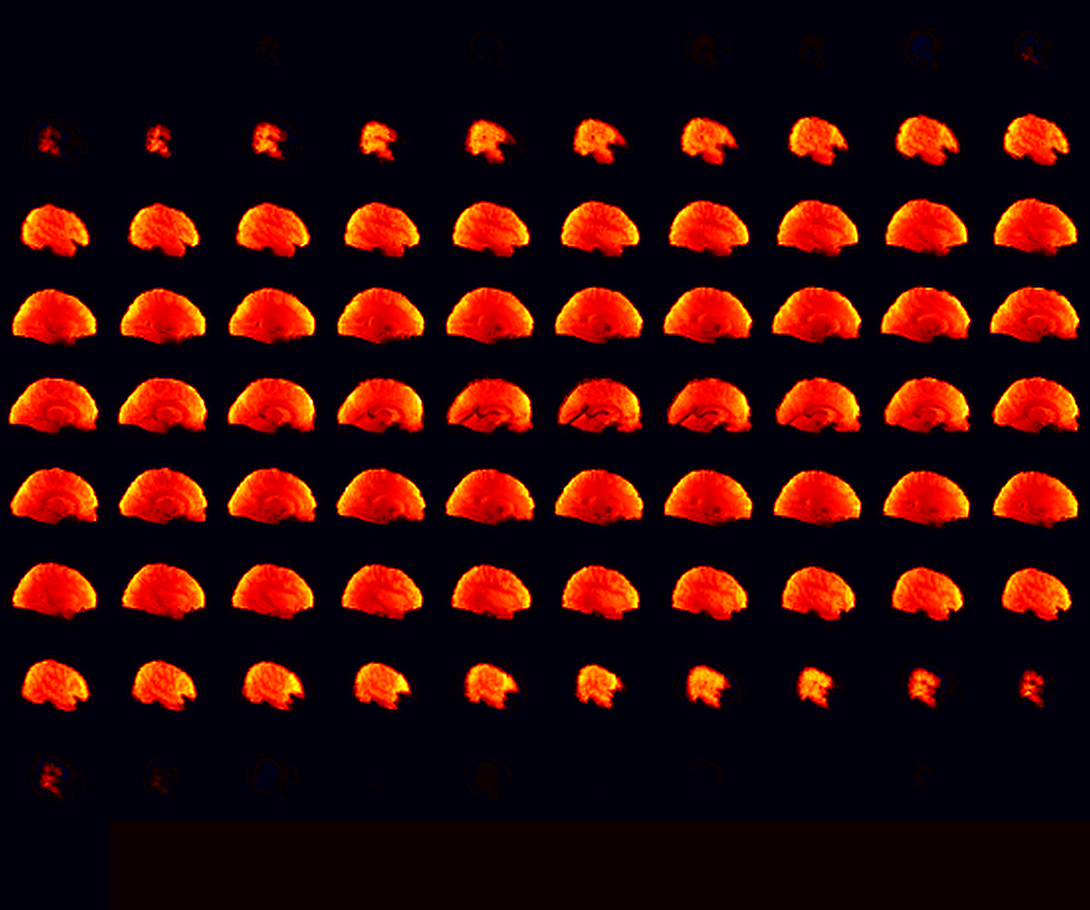

In [3]:
import matplotlib.pyplot as plt
from nilearn import image
from nilearn import plotting

mean_image = image.mean_img(development_dataset.func[0])
plotting.view_img(mean_image, threshold=None)

## Extracting signal from fMRI volumes

As you can see, this data is decidedly not tabular !
What we'd like is to extract and transform relevant features from this data into a tabular format that we can more easily work with.
To do this, we'll use nilearn's Masker objects.
What are the masker objects ?
First, let's think about what masking fMRI data is doing:

```{figure} images/masking.jpg
---
height: 350px
name: masking
---
Masking fMRI data.
```

Essentially, we can imagine overlaying a 3D grid on an image.
Then, our mask tells us which cubes or “voxels” (like 3D pixels) to sample from.
Since our Nifti images are 4D files, we can’t overlay a single grid –
instead, we use a series of 3D grids (one for each volume in the 4D file),
so we can get a measurement for each voxel at each timepoint.

Masker objects allow us to apply these masks !
To start, we need to define a mask (or masks) that we'd like to apply.
This could correspond to one or many regions of interest.
Nilearn provides methods to define your own functional parcellation (using clustering algorithms such as k-means),
and it also provides access to other atlases that have previously been defined by researchers.

## Choosing regions of interest

In this tutorial,
we'll use the MSDL (multi-subject dictionary learning; {cite}`Varoquaux_2011`) atlas,
which defines a set of _probabilistic_ regions of interest (ROIs) across the brain.

In [4]:
msdl_atlas = datasets.fetch_atlas_msdl()

msdl_coords = msdl_atlas.region_coords
n_regions = len(msdl_coords)

print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_atlas.networks))


Dataset created in /home/runner/nilearn_data/msdl_atlas



MSDL has 39 ROIs, part of the following networks :
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


Downloaded 209734 of 209734 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
Extracting data from /home/runner/nilearn_data/msdl_atlas/5d25e157f36214b8ca9a12fd417aac1c/MSDL_rois.zip..... done.
/opt/hostedtoolcache/Python/3.7.8/x64/lib/python3.7/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Nilearn also provides us with an easy way to view this atlas directly:

/opt/hostedtoolcache/Python/3.7.8/x64/lib/python3.7/site-packages/nilearn/plotting/displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


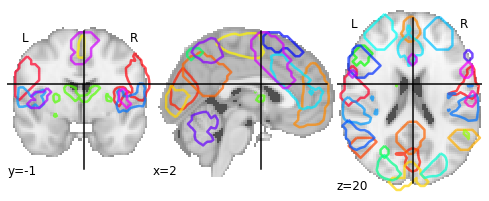

In [5]:
plotting.plot_prob_atlas(msdl_atlas.maps)

We'd like to supply these ROIs to a Masker object.
All Masker objects share the same basic structure and functionality,
but each is designed to work with a different kind of ROI.

The canonical [`nilearn.input_data.NiftiMasker`](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html) works well if we want to apply a single mask to the data,
like a single region of interest.

But what if we actually have several ROIs that we'd like to apply to the data all at once?
If these ROIs are non-overlapping,
as in "hard" or deterministic parcellations,
then we can use [`nilearn.input_data.NiftiLabelsMasker`](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiLabelsMasker.html).
Because we're working with "soft" or probabilistic ROIs,
we can instead supply these ROIs to [`nilearn.input_data.NiftiMapsMasker`](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMapsMasker.html).

For a full list of the available Masker objects,
see [the Nilearn documentation](https://nilearn.github.io/modules/reference.html#module-nilearn.input_data).

To the `NiftiMapsMasker` object,
we can supply our MSDL atlas-defined ROIs,
as well as resampling, filtering, and detrending options.

In [6]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
    msdl_atlas.maps, resampling_target="data",
    t_r=2, detrend=True,
    low_pass=0.1, high_pass=0.01).fit()

One thing you might notice from the above code is that immediately after defining the masker object,
we call the `.fit` method on it.


They also allow us to perform other operations,
like correcting for measured signals of no interest (e.g., head motion).
Our `development_dataset` also includes several of these signals of no interest that were generated by fMRIPrep pre-processing.
We can access these with the `confounds` attribute,
using `development_dataset.confounds`.

Let's quickly check what these look like for our first participant:

In [7]:
import pandas as pd

pd.read_table(development_dataset.confounds[0]).head()

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,framewise_displacement,a_comp_cor_00,a_comp_cor_01,a_comp_cor_02,a_comp_cor_03,a_comp_cor_04,a_comp_cor_05,csf,white_matter
0,-0.000233,-0.076885,0.062321,0.000732,0.000352,0.000841,0.000000,-0.099871,-0.007286,0.001780,-0.008073,0.030945,-0.022393,439.699409,451.645460
1,-0.006187,-0.078395,0.056773,0.000112,0.000187,0.000775,0.055543,-0.019437,-0.042308,0.016735,-0.012099,0.088777,-0.006171,439.471640,451.103437
2,-0.000227,-0.069893,0.083102,0.000143,0.000364,0.000716,0.054112,0.009096,-0.053206,-0.030388,-0.052925,0.019922,0.014776,439.744498,450.981505
3,0.002492,-0.074707,0.060337,0.000202,0.000818,0.000681,0.057667,0.060195,-0.083195,0.003578,-0.037011,0.026946,0.002505,440.772620,450.600261
4,-0.000226,-0.084204,0.085079,0.000183,0.000548,0.000682,0.051438,0.049833,-0.089819,-0.020825,-0.079329,0.008516,-0.000938,440.115442,450.678959


## An example classification problem

This example compares different kinds of functional connectivity between
regions of interest: correlation, partial correlation, and tangent space
embedding.

The resulting connectivity coefficients can be used to
discriminate children from adults. In general, the tangent space embedding
**outperforms** the standard correlations: see {cite}`Dadi_2019`
for a careful study.

## Load brain development fMRI dataset and MSDL atlas

We study only 30 subjects from the dataset, to save computation time.

In [8]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import LinearSVC

from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn import input_data
from nilearn import datasets

# for NHA env, will need to update to include `data_dir='~/data'`
development_dataset = datasets.fetch_development_fmri(n_subjects=30)

## Region signals extraction

To extract regions time series, we instantiate a
:class:`nilearn.input_data.NiftiMapsMasker` object and pass the atlas the
file name to it, as well as filtering band-width and detrending option.

Then we compute region signals and extract useful phenotypic informations.

In [9]:
children = []
pooled_subjects = []
groups = []  # child or adult
for func_file, confound_file, phenotypic in zip(
        development_dataset.func,
        development_dataset.confounds,
        development_dataset.phenotypic):
    time_series = masker.transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    if phenotypic['Child_Adult'] == 'child':
        children.append(time_series)
    groups.append(phenotypic['Child_Adult'])

print('Data has {0} children.'.format(len(children)))

Data has 24 children.


## ROI-to-ROI correlations of children

The simpler and most commonly used kind of connectivity is correlation. It
models the full (marginal) connectivity between pairwise ROIs. We can
estimate it using :class:`nilearn.connectome.ConnectivityMeasure`.

In [10]:
correlation_measure = ConnectivityMeasure(kind='correlation')

From the list of ROIs time-series for children, the
`correlation_measure` computes individual correlation matrices.

In [11]:
correlation_matrices = correlation_measure.fit_transform(children)

All individual coefficients are stacked in a unique 2D matrix.

In [12]:
print('Correlations of children are stacked in an array of shape {0}'
      .format(correlation_matrices.shape))

Correlations of children are stacked in an array of shape (24, 39, 39)


as well as the average correlation across all fitted subjects.

In [13]:
mean_correlation_matrix = correlation_measure.mean_
print('Mean correlation has shape {0}.'.format(mean_correlation_matrix.shape))

Mean correlation has shape (39, 39).


We display the connectome matrices of the first 3 children

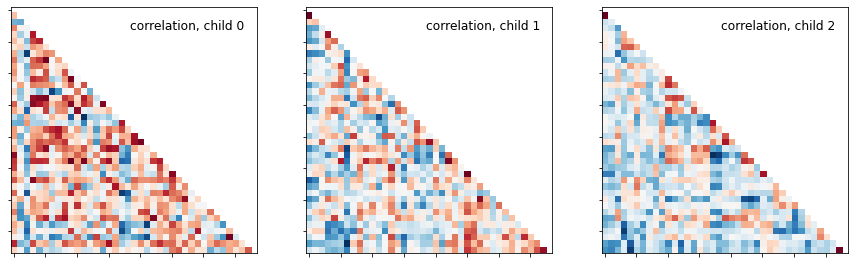

In [14]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='correlation, child {}'.format(i))

The blocks structure that reflect functional networks are visible.

Now we display as a connectome the mean correlation matrix over all children.

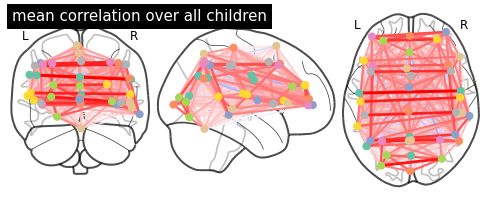

In [15]:
plotting.plot_connectome(mean_correlation_matrix, msdl_coords,
                         title='mean correlation over all children')

## Studying partial correlations

We can also study **direct connections**, revealed by partial correlation
coefficients. We just change the `ConnectivityMeasure` kind

In [16]:
partial_correlation_measure = ConnectivityMeasure(kind='partial correlation')
partial_correlation_matrices = partial_correlation_measure.fit_transform(
    children)

Most of direct connections are weaker than full connections.

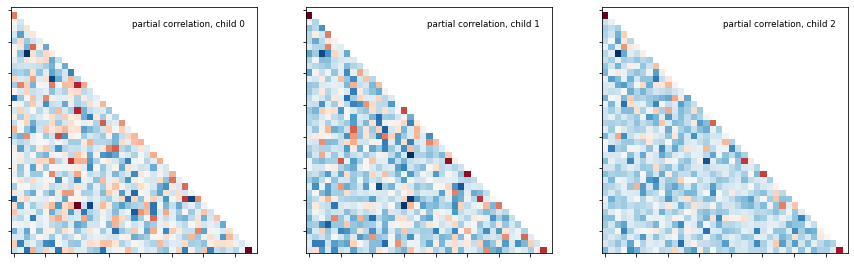

In [17]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(partial_correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='partial correlation, child {}'.format(i))

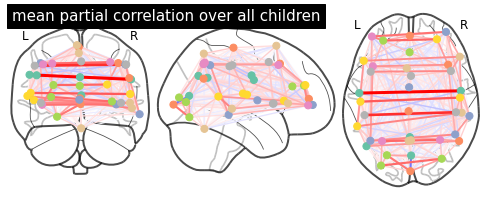

In [18]:
plotting.plot_connectome(
    partial_correlation_measure.mean_, msdl_coords,
    title='mean partial correlation over all children')

## Extract subjects variabilities around a group connectivity

We can use **both** correlations and partial correlations to capture
reproducible connectivity patterns at the group-level.
This is done by the tangent space embedding.

In [19]:
tangent_measure = ConnectivityMeasure(kind='tangent')

We fit our children group and get the group connectivity matrix stored as
in `tangent_measure.mean_`, and individual deviation matrices of each subject
from it.

In [20]:
tangent_matrices = tangent_measure.fit_transform(children)

`tangent_matrices` model individual connectivities as
**perturbations** of the group connectivity matrix `tangent_measure.mean_`.
Keep in mind that these subjects-to-group variability matrices do not
directly reflect individual brain connections. For instance negative
coefficients can not be interpreted as anticorrelated regions.

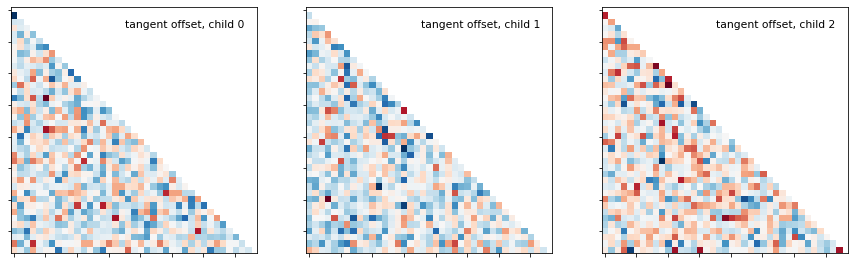

In [21]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (matrix, ax) in enumerate(zip(tangent_matrices, axes)):
    plotting.plot_matrix(matrix, tri='lower', colorbar=False, axes=ax,
                         title='tangent offset, child {}'.format(i))

The average tangent matrix cannot be interpreted, as individual matrices
represent deviations from the mean, which is set to 0.

## What kind of connectivity is most powerful for classification?

We will use connectivity matrices as features to distinguish children from
adults. We use cross-validation and measure classification accuracy to
compare the different kinds of connectivity matrices.
We use random splits of the subjects into training/testing sets.
StratifiedShuffleSplit allows preserving the proportion of children in the
test set.

In [22]:
kinds = ['correlation', 'partial correlation', 'tangent']
_, classes = np.unique(groups, return_inverse=True)
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=5)
pooled_subjects = np.asarray(pooled_subjects)

scores = {}
for kind in kinds:
    scores[kind] = []
    for train, test in cv.split(pooled_subjects, classes):
        # *ConnectivityMeasure* can output the estimated subjects coefficients
        # as a 1D arrays through the parameter *vectorize*.
        connectivity = ConnectivityMeasure(kind=kind, vectorize=True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects[train])
        # fit the classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(
            connectivity.transform(pooled_subjects[test]))
        # store the accuracy for this cross-validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

display the results

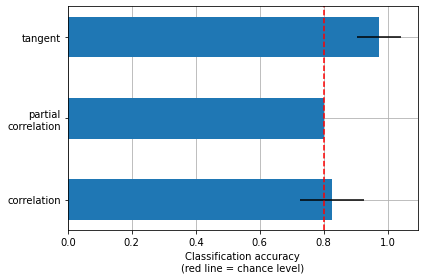

In [23]:
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
yticks = [k.replace(' ', '\n') for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.8, color='red', linestyle='--')
plt.xlabel('Classification accuracy\n(red line = chance level)')
plt.tight_layout()

This is a small example to showcase nilearn features. In practice such
comparisons need to be performed on much larger cohorts and several
datasets.
{cite}`Dadi_2019` showed that across many cohorts and clinical questions,
the tangent kind should be preferred.

```{bibliography} references.bib
:style: unsrt
```